# Zero-shot Classification Results Quantification

In [1]:
# imports
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize


In [2]:
# config
OUT_ROOT = "/midtier/paetzollab/scratch/ads4015/temp_selma_classification_preds_zeroshot"

MODELS = ["image_clip", "image_only", "random"]
SOURCES = ["selma", "mesospim", "allen_human"]


In [3]:
rows = []

# load all embeddings metadata
for model in MODELS:
    meta_files = glob.glob(os.path.join(OUT_ROOT, "embeddings", model, "**", "*.json"), recursive=True)

    for mp in meta_files:
        with open(mp, "r") as f:
            meta = json.load(f)

        npy_path = mp.replace(".json", ".npy")
        if not os.path.exists(npy_path):
            continue

        # load embedding
        emb = np.load(npy_path).astype(np.float32)

        # save row data
        rows.append({
            "model": model,
            "source": meta["source"],
            "label": meta["label"],
            "path": meta["path"],
            "rel_id": meta["rel_id"],
            "emb_path": npy_path,
            "dim": emb.shape[0],
        })

df_emb = pd.DataFrame(rows)
print(df_emb.shape)
df_emb.head()


(486, 7)


,model,source,label,path,rel_id,emb_path,dim
0,image_clip,selma,amyloid_plaque,/midtier/paetzollab/scratch/ads4015/data_selma...,selma/amyloid_plaque_patches/patch_004_vol030_ch0,/midtier/paetzollab/scratch/ads4015/temp_selma...,36
1,image_clip,selma,amyloid_plaque,/midtier/paetzollab/scratch/ads4015/data_selma...,selma/amyloid_plaque_patches/patch_012_vol033_ch0,/midtier/paetzollab/scratch/ads4015/temp_selma...,36
2,image_clip,selma,amyloid_plaque,/midtier/paetzollab/scratch/ads4015/data_selma...,selma/amyloid_plaque_patches/patch_002_vol023_ch0,/midtier/paetzollab/scratch/ads4015/temp_selma...,36
3,image_clip,selma,amyloid_plaque,/midtier/paetzollab/scratch/ads4015/data_selma...,selma/amyloid_plaque_patches/patch_005_vol001_ch0,/midtier/paetzollab/scratch/ads4015/temp_selma...,36
4,image_clip,selma,amyloid_plaque,/midtier/paetzollab/scratch/ads4015/data_selma...,selma/amyloid_plaque_patches/patch_014_vol006_ch0,/midtier/paetzollab/scratch/ads4015/temp_selma...,36


In [4]:
def run_nearest_centroid_pooled(df_sub, test_size=0.2, seed=0):
    """
    Zero-shot classification across ALL datasets pooled together.
    """
    X = np.stack([np.load(p).astype(np.float32) for p in df_sub["emb_path"].values])
    y = df_sub["label"].values

    # L2 normalize → cosine-equivalent
    X = normalize(X, norm="l2")

    splitter = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=seed
    )

    train_idx, test_idx = next(splitter.split(X, y))
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    clf = NearestCentroid(metric="euclidean")
    clf.fit(Xtr, ytr)
    yhat = clf.predict(Xte)

    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average="macro")

    labels_sorted = sorted(np.unique(y))
    cm = confusion_matrix(yte, yhat, labels=labels_sorted)

    return {
        "acc": acc,
        "macro_f1": f1m,
        "labels": labels_sorted,
        "y_true": yte,
        "y_pred": yhat,
        "clf": clf,
    }, cm


In [5]:
def add_zero_shot_predictions_pooled(df_sub):
    """
    Trains a pooled nearest-centroid classifier
    and adds a 'pred' column to df_sub.
    """
    df_sub = df_sub.copy()

    # ---- load embeddings ----
    X = np.stack([
        np.load(p).astype(np.float32)
        for p in df_sub["emb_path"].values
    ])
    y = df_sub["label"].values

    # normalize → cosine-equivalent
    X = normalize(X, norm="l2")

    # ---- train classifier on ALL samples ----
    clf = NearestCentroid(metric="euclidean")
    clf.fit(X, y)

    # ---- predict ALL samples ----
    yhat = clf.predict(X)

    df_sub["pred"] = yhat
    return df_sub


In [6]:
results = {}
confmats = {}

for model in MODELS:
    sub = df_emb[df_emb["model"] == model].copy()

    print(f"\n=== Pooled zero-shot classification: {model} ===")
    print(f"Total samples: {len(sub)}")
    print(f"Classes: {sorted(sub['label'].unique())}")

    metrics, cm = run_nearest_centroid_pooled(sub, test_size=0.2, seed=0)

    results[model] = metrics
    confmats[model] = cm

    print(f"Accuracy   : {metrics['acc']:.3f}")
    print(f"Macro F1   : {metrics['macro_f1']:.3f}")



=== Pooled zero-shot classification: image_clip ===
Total samples: 162
Classes: ['TPH2', 'VIP_ASLM_off', 'VIP_ASLM_on', 'amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'cr', 'lec', 'nn', 'npy', 'vessels', 'yo']
Accuracy   : 0.121
Macro F1   : 0.064

=== Pooled zero-shot classification: image_only ===
Total samples: 162
Classes: ['TPH2', 'VIP_ASLM_off', 'VIP_ASLM_on', 'amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'cr', 'lec', 'nn', 'npy', 'vessels', 'yo']
Accuracy   : 0.030
Macro F1   : 0.017

=== Pooled zero-shot classification: random ===
Total samples: 162
Classes: ['TPH2', 'VIP_ASLM_off', 'VIP_ASLM_on', 'amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'cr', 'lec', 'nn', 'npy', 'vessels', 'yo']
Accuracy   : 0.152
Macro F1   : 0.132


In [7]:
df_with_preds = []

for model in MODELS:
    sub = df_emb[df_emb["model"] == model].copy()
    sub = add_zero_shot_predictions_pooled(sub)
    df_with_preds.append(sub)

df_emb = pd.concat(df_with_preds, ignore_index=True)


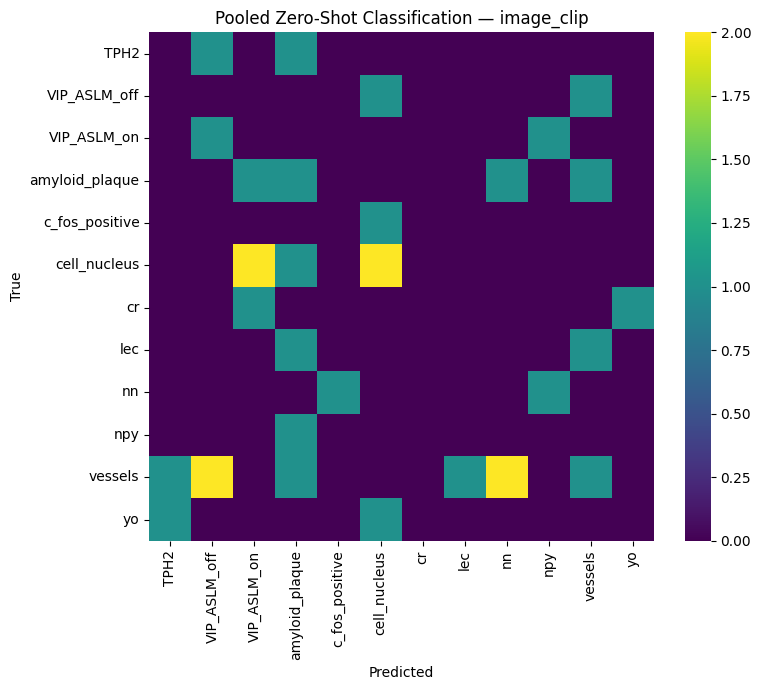

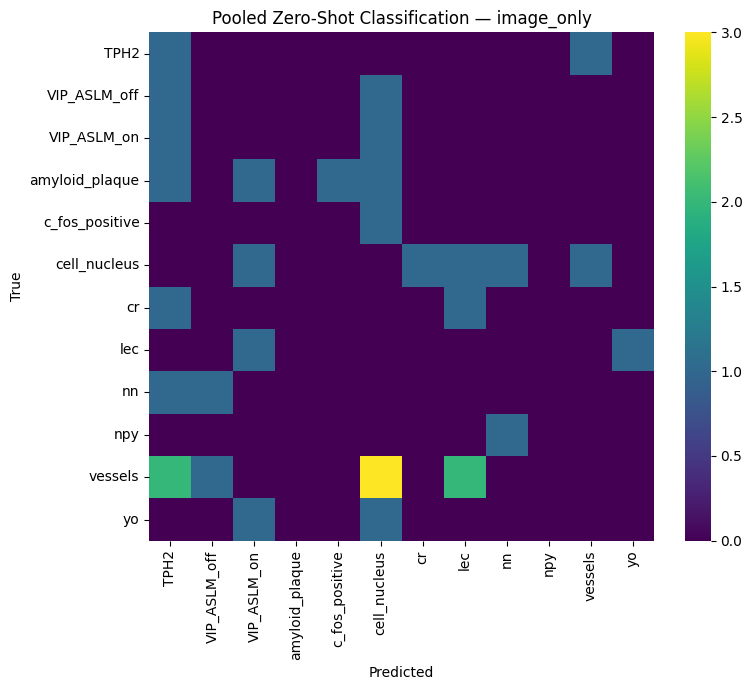

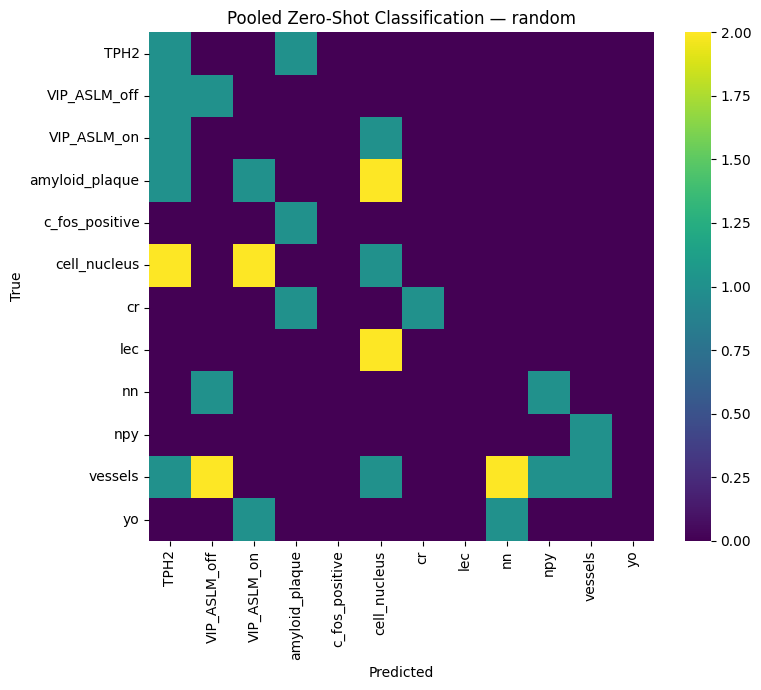

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

for model, metrics in results.items():
    labels = metrics["labels"]
    cm = confmats[model]

    plt.figure(figsize=(8, 7))
    sns.heatmap(
        cm,
        xticklabels=labels,
        yticklabels=labels,
        annot=False,
        cmap="viridis"
    )
    plt.title(f"Pooled Zero-Shot Classification — {model}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [9]:
summary = pd.DataFrame([
    {
        "model": model,
        "accuracy": metrics["acc"],
        "macro_f1": metrics["macro_f1"],
    }
    for model, metrics in results.items()
])

display(summary)


,model,accuracy,macro_f1
0,image_clip,0.121212,0.063889
1,image_only,0.030303,0.016667
2,random,0.151515,0.132407


## Show Sample Images

In [18]:
import os
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


In [19]:
def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def normalize_img(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

def center_slice(vol):
    return vol[:, :, vol.shape[-1] // 2]


In [20]:
def sample_patches_per_class(df, n_per_class=2, seed=42):
    """
    Randomly sample N image paths per GT class.
    """
    random.seed(seed)
    selected = []

    for cls, sub in df.groupby("label"):
        paths = sub["path"].unique().tolist()
        if len(paths) == 0:
            continue
        chosen = random.sample(paths, min(n_per_class, len(paths)))
        selected.extend(chosen)

    return selected


In [21]:
MODEL_ORDER = ["image_clip", "image_only", "random"]

MODEL_TITLES = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
}


In [53]:
def plot_zero_shot_examples(
    df_emb,
    n_per_class=2,
    seed=100,
    title="Zero-shot classification examples"
):
    """
    Clean layout:
    - Left: image (center slice)
    - Right: neatly formatted GT + predictions (no overlap)
    """

    paths = sample_patches_per_class(
        df_emb, n_per_class=n_per_class, seed=seed
    )

    n_rows = len(paths)

    fig, axes = plt.subplots(
        n_rows,
        2,
        figsize=(5, 2.0 * n_rows),
        gridspec_kw={"width_ratios": [1.0, 2.0]},
    )

    if n_rows == 1:
        axes = axes[None, :]

    for r, path in enumerate(paths):
        sub = df_emb[df_emb["path"] == path]

        gt = sub["label"].iloc[0]

        # ------------------
        # Image panel
        # ------------------
        img = normalize_img(load_nifti(path))
        sl = center_slice(img)

        ax_img = axes[r, 0]
        ax_img.imshow(sl, cmap="gray")
        ax_img.set_title("Image", fontsize=11)
        ax_img.axis("off")

        # ------------------
        # Text panel
        # ------------------
        ax_txt = axes[r, 1]
        ax_txt.axis("off")

        lines = []
        lines.append(f"GT:  {gt}")

        for model in MODEL_ORDER:
            row = sub[sub["model"] == model]
            pred = row["pred"].iloc[0] if len(row) else "MISSING"
            lines.append(f"{MODEL_TITLES[model]}:  {pred}")

        # Draw text line-by-line
        y = 0.9
        dy = 0.18

        for i, line in enumerate(lines):
            is_gt = line.startswith("GT:")
            color = "black"

            if not is_gt:
                pred = line.split(":")[1].strip()
                color = "black" if pred == gt else "firebrick"

            ax_txt.text(
                0.0, y,
                line,
                fontsize=11,
                fontweight="bold" if is_gt else "normal",
                color=color,
                family="monospace",
            )
            y -= dy

    plt.suptitle(title, fontsize=10)
    plt.tight_layout(rect=[0, 0, 0.5, 0.98])
    plt.subplots_adjust(right=1)
    plt.show()


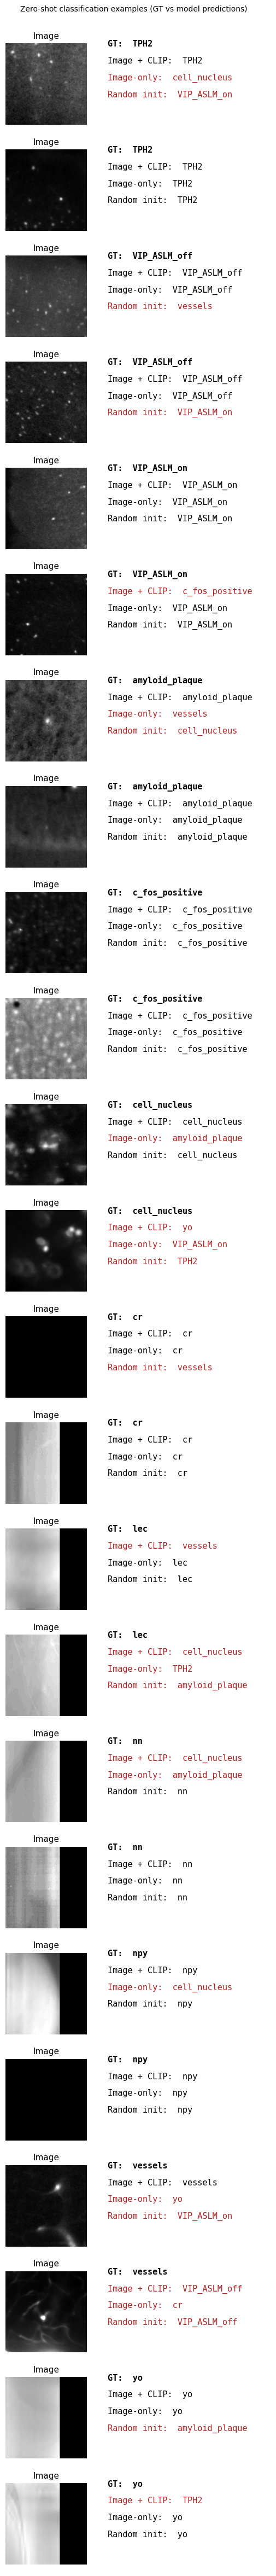

In [54]:
plot_zero_shot_examples(
    df_emb,
    n_per_class=2,
    seed=100,
    title="Zero-shot classification examples (GT vs model predictions)"
)
